# Part of Speech Tagging via various Learning Methods

### What is a Part of Speech Tagger

The process of part of speech tagging assigns labels to words in a sentence corresponding to their function within that sentence, i.e noun, verb, adjective, etc. While this is often quite simple for humans to go through and annotate, it quite difficult to do automatically, as the meaning of a word may change drastically depending on its position within a sentence. 

Part of speech tagging is considered an essential component of Natural Language Processing as it plays a significant role in sentiment analysis, data extraction, and syntactic structure among others. Being able to correctly identify the role of a word provides information about the sentence as a whole, as well as the neighbors of that word. Below are short examples using the default tagger provided by NLTK. You will need to download it with the following commands:

  ```python
  >>>nltk.download('maxent_treebank_pos_tagger')
  >>>nltk.download('punkt')
  >>>nltk.download('averaged_perceptron_tagger')
  ```

In [1]:
from nltk import word_tokenize, pos_tag

sentence = 'Part of Speech Tagging is amazing!'

pos_tag(word_tokenize(sentence))

[('Part', 'NN'),
 ('of', 'IN'),
 ('Speech', 'NNP'),
 ('Tagging', 'NNP'),
 ('is', 'VBZ'),
 ('amazing', 'JJ'),
 ('!', '.')]

### Collecting and Cleaning the Data
As you can see, each word has been assigned a specific label. To build our own tagger, let us start by downloading the data set that we will be working with. For the purposes of this tutorial, we will use pre-tagged data obtained from the NLTK Brown corpus. You will need to run the following two commands to obtain the relevant data.

  ```python
  >>>nltk.download('brown')
  >>>nltk.download('universal_tagset')
  ```
The first line will download the Brown corpus, while the universal tagset will be used to assign standardized part of speech tags to the words. For now, we will use the simplified universal tag set shown below. However, many taggers, such as the default nltk tagger used above, often use tag sets with many times more labels in order to capture information such as plurality, tense, possessiveness, etc. 

We are now ready to collect the tagged sentences from the Brown Corpus.
 

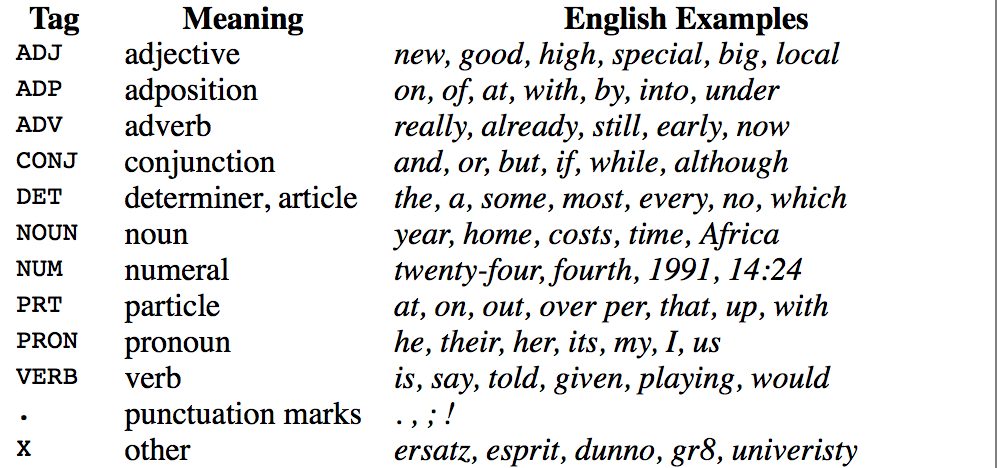

In [2]:
from IPython.core.display import Image, display
display(Image('https://imgur.com/QmMpzGP.png'))

In [1]:
import nltk

taggeddata = nltk.corpus.brown.tagged_sents(tagset='universal')
print(taggeddata[0])
print(len(taggeddata))

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
57340


Printing out the first few elements in tagged data reveals that the output of tagged sentences is a list of sentences, where each sentence is broken up into tuples containing the word and its tag. For example, the first sentence is "The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced "no evidence" that any irregularities took place."

Now that we have a collection of tagged sentences, we will now extract our training and test data and labels. In the previous code block, we were able to determine that the full data set contains 57340 sentences. To make things simple, we will use the first 50,000 sentences as our training set and the rest as our test set. After we have split our data, we can then map all the words in our training data set to a number, as this will help our learning algorithm down the road. We will use a default dict the default value set to -1 in order to handle cases that dont appear in our training set. We will also add mappings to indicate the beginning and end of sentences, where <span>"@@@"</span> will represent the beginning and <span>"###"</span> will represent the end.

In [3]:
from collections import defaultdict

def createMappings(data):
    wordmap = defaultdict(lambda:-1)
    wordmap["@@@"] = 0
    wordmap["###"] = 1
    counter = 2
    for sentence in data:
        for word, tag in sentence:
            if word not in wordmap:
                wordmap[word] = counter
                counter += 1
    return wordmap
                
trainingset = taggeddata[:50000]
testset = taggeddata[50000:]

wordmap = createMappings(trainingset)
list(wordmap.items())[:20]

[('@@@', 0),
 ('###', 1),
 ('The', 2),
 ('Fulton', 3),
 ('County', 4),
 ('Grand', 5),
 ('Jury', 6),
 ('said', 7),
 ('Friday', 8),
 ('an', 9),
 ('investigation', 10),
 ('of', 11),
 ("Atlanta's", 12),
 ('recent', 13),
 ('primary', 14),
 ('election', 15),
 ('produced', 16),
 ('``', 17),
 ('no', 18),
 ('evidence', 19)]

### Splitting the Data and Extracting Features
The next step is to prepare our training set so that we can feed into a model. However, instead of just splitting our tuples, we will also create a function that will produce a set of features for each word. For the models in this tutorial, we will specify the following features:

| **Features** | **Definition** | 
|----------|-------------|
| prev      | The mapping for the word that appeared previously in the sentence |
| next | The mapping for the word that appeared next in the sentence |
| lowercase | boolean representing if the word is all lower case |
| capitalized | boolean representing if the first letter is capitalized |
| isnumber | boolean representing if the current word is all numbers |
| word | the word mapping of the current word | 
| prefix | The first character of the current word | 
| prefix1 | The first two character of the current word | 
| prefix2 | The first three character of the current word |
| suffix | The last character of the current wordr | 
| suffix1 | The last two character of the current word |
| suffix2 | The last three character of the current word |

As you can imagine, this provides our model with a lot more information than just simply using the word as the input.

In [4]:
def featurify(sentence, mapping):
    for i in range(len(sentence)):
        word = sentence[i]
        feature = {}
        # Some features suggested from http://nlpforhackers.io/training-pos-tagger/
        if i == 0:
            feature['prev'] = mapping['***']
        else:
            feature['prev'] = mapping[sentence[i-1]]
        if i == len(sentence)-1:
            feature['next'] = mapping['###']
        else:
            feature['next'] = mapping[sentence[i+1]]
        feature['lowercase'] = word.lower() == word
        feature['capitalized'] = word[0].upper() == word[0]
        feature['number'] = word.isdigit()
        feature['word'] = mapping[word]
        feature['prefix'] = word[:1]
        feature['prefix1'] = word[:2]
        feature['prefix2'] = word[:3]
        feature['suffix'] = word[-1:]
        feature['suffix1'] = word[-2:]
        feature['suffix2'] = word[-3:]
        yield feature
        
def splitData(taggedsentences, mapping):
    # taggedsentences: a list of sentences whose words have been tagged
    labels = []
    words = []
    featwords = []
    for sentence in taggedsentences:
        for word, tag in sentence:
            words.append(mapping[word])
            labels.append(tag)
        featuredsentence = featurify([word for word, tag in sentence], mapping)
        featwords += list(featuredsentence)
    return featwords, words, labels

feattrain, wordtrain, labeltrain = splitData(trainingset, wordmap)
feattest, wordtest, labeltest = splitData(testset, wordmap)

Note that while the feature values for prev, next, and word are all integers that were mapped to those specific words, the prefix and suffix features are substrings of the original word. While this is not ideal, it would be a pain to enumerate all the possibilities and assign mappings. Instead, we will allow sklearn to create a one hot encoding of the prefix and suffix categories using the sklearn.DictVectorizer class. This is ideal as it handles all the enumerations that show up in our training set automatically while also being represented in the fast SciPy sparse matrix format. In the case that an prefix/suffix shows up in our test set, all those categories will simply be set to 0.

In [5]:
from sklearn.feature_extraction import DictVectorizer
def getVectorizer(data):
    vec = DictVectorizer(sparse=True)
    ohdata = vec.fit_transform(data)
    return vec, ohdata

def onehotEncode(vec, data):
    ohdata = vec.transform(data)
    return ohdata

vectorizer, ohfeattrain = getVectorizer(feattrain)
ohfeattest = onehotEncode(vectorizer, feattest)

ohfeattrain[0]

<1x13583 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

### Building the Models
Now that we have finished preparing our data for learning, our next choice is what sort of model should we train on our data. We will implement several classifiers and test their performance on our data. In order to accomplish this, we will use the following classifiers provided by sklearn: 

1. Logistic Regression - attempts to learn multiple seperating hyperplanes that will be used to distinguish the word's label based on its distance from those hyperplanes. Assumes that the data is linearly seperable. We will use the sag solver as we have a large data set, and we will enable the multi-class labelling.
2. KNeighbors Classifier - stores all the examples during training, and then assigns labels to test words by choosing the k closest neighbors. Assumes that the all features of the data are equally important in determining the closest neighbor. We will use the default value of k = 5. 
3. Decision Tree Classifier - creates a tree where at each node, a feature is selected such that the distribution of the data at that node results in the lowest possible entropy.
4. Multi-Layer Perceptron Classifier - creates layers of hidden states whose weights are trained to minimize the loss of the predictions. We will use a simple perceptron with 2 hidden layers that have 50 neurons each.


In [6]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

def learnLogReg(data, labels):
    logreg = sklearn.linear_model.LogisticRegression(solver="sag", multi_class="multinomial")
    logreg = logreg.fit(data, labels)
    return logreg

def learnKNN(data, labels):
    knn = sklearn.neighbors.KNeighborsClassifier()
    knn = knn.fit(data, labels)
    return knn

def learnTree(data, labels):
    tree = DecisionTreeClassifier()
    tree = tree.fit(data, labels)
    return tree

def learnMLP(data, labels):
    mlp = MLPClassifier(hidden_layer_sizes = (50, 50))
    mlp = mlp.fit(data, labels)
    return mlp

Before we train our models though, lets take a look at how many training examples we have after our preprocessing.

In [7]:
print(len(labeltrain))

1039920


With over a million training examples, all of our models will take an extremely long time to train. Therefore, let's reduce the size of our training set just for the purposes of this tutorial and take just the first 100,000 samples. For, we will also time our models on how long they take to train. This can be done by adding the following line at the top of each cell. 

  ```python
  >>>%%time
  ```
  
In addition to using our extracted features, we will also train models using just the words themselves in order to compare and justify the creation of our features. We will need to use numpy to reshape our lists into an acceptable format for the SciKit models, as they are currently in a 1-D list format, but are required to be 2-D arrays.

In [8]:
import numpy as np

simpletrain = np.array(wordtrain[:20000]).reshape(-1,1)
simpletest = np.array(wordtest).reshape(-1,1)
finalfeattrain = ohfeattrain[:20000]
finallabeltrain = labeltrain[:20000]

simpleLRModel = learnLogReg(simpletrain, finallabeltrain)
simpleKNNModel = learnKNN(simpletrain, finallabeltrain)
simpleDecisionModel = learnTree(simpletrain, finallabeltrain)
simplePerceptronModel = learnMLP(simpletrain, finallabeltrain)

In [9]:
%%time
LRModel = learnLogReg(finalfeattrain, finallabeltrain)

CPU times: user 1.64 s, sys: 4.62 ms, total: 1.65 s
Wall time: 1.65 s


/Users/sunil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [10]:
%%time
KNNModel = learnKNN(finalfeattrain, finallabeltrain)

CPU times: user 6.65 ms, sys: 1.58 ms, total: 8.23 ms
Wall time: 6.21 ms


In [11]:
%%time
DecisionModel = learnTree(finalfeattrain, finallabeltrain)

CPU times: user 883 ms, sys: 3.95 ms, total: 887 ms
Wall time: 884 ms


In [12]:
%%time
PerceptronModel = learnMLP(finalfeattrain, finallabeltrain)

CPU times: user 39.8 s, sys: 11.5 s, total: 51.3 s
Wall time: 51.1 s


To analyze the total time taken to train each model, we want the total time designated under CPU. From these, we can see that of the four, the multi-layer perceptron takes significantly more time than the rest, while the KNN model takes almost no time at all. This is because the KNN Model simply stores all the examples without really doing any processing. On the other hand, the Perceptron model is tuning hundreds of parameters as it looks at each training example, resulting in its two minute run time. However, as of now, none of these timings are very significant as they are all one time costs. The larger issue is determining the accuracy and speed at which the models are able to predict on a test set.

### Predicting and Scoring our Models

Evaluating these functions is fairly simple as we can just use the built-in SciKit learn function, score, provided for every model. We will evaluate the scores of both are simple and featured models. In addition, we will also time our featured models using the same method as before.

In [13]:
sLRScore = simpleLRModel.score(simpletest, labeltest)
sKNNScore = simpleKNNModel.score(simpletest, labeltest)
sDecisionScore = simpleDecisionModel.score(simpletest, labeltest)
sMLPScore = simplePerceptronModel.score(simpletest, labeltest)

In [14]:
%%time
LRScore = LRModel.score(ohfeattest, labeltest)

CPU times: user 55.8 ms, sys: 2.55 ms, total: 58.3 ms
Wall time: 57 ms


In [15]:
%%time
KNNScore = KNNModel.score(ohfeattest, labeltest)

CPU times: user 2min 6s, sys: 5min 34s, total: 7min 40s
Wall time: 11min 45s


In [16]:
%%time
DecisionScore = DecisionModel.score(ohfeattest, labeltest)

CPU times: user 96.5 ms, sys: 81.8 ms, total: 178 ms
Wall time: 285 ms


In [17]:
%%time
MLPScore = PerceptronModel.score(ohfeattest, labeltest)

CPU times: user 417 ms, sys: 133 ms, total: 550 ms
Wall time: 337 ms


If you choose to run these models yourself, they should result in values that are fairly similar to those in the table below. To streamline this tutorial, I have purposefully removed the cells that score and time the simple models as they follow the exact format of the other test cells.

| **Model** | **Accuracy** | **Time (seconds)** |
|----------|-------------|
| Simple Logistic Regression | 0.16357444422455308 | 0.0935
| Feature Logistic Regression | 0.38214097235965433 | 59
| Simple KNN | 0.76062075334784618 | 0.377
| Feature KNN | 0.35543000000000002 | 460
| Simple Decision Tree | 0.7761478329705126 | 0.0756
| Feature Decision Tree | 0.86376904809024346 | 0.217
| Simple Perceptron | 0.26882545022758758 | 0.431
| Feature Perceptron | 0.80440662312817468 | 0.514

Before we compare the models with each other, note that the addition of the features has improved the accuracy of the models across the board by a fairly large amount. The only one that has failed to do so is the KNN model. In fact, although we had noted that KNN's had the lowest training time by far, when it comes to predictions, it is significantly worse than any of the other 3 models. This is due to the fact that for every single training example, the KNN algorithm needs to calculate the distance to every single point provided in the training data. In fact, as an experiment, you can try increasing the size of the training data to include 100,000 examples and then attempting to score the featured test data. Chances are that your kernel will die due to memory overflow. 

Overall, the decision tree seems to have proved itself as the most effective model, maintaining relatively low prediction times while also holding the highest accuracy of the bunch. This is likely due to the slightly deterministic nature of sentence tagging. If a word ends with 'ly', it is likely an adverb, the word following an article('the', 'a', 'an') is likely either an adjective or a noun, etc. As a result, it makes sense that splitting the dataset based on the feature values results in the highest accuracy.

### Further Resources

To find additional information on Part of Speech tagging as well other methods used in this tutorial, the following links may be helpful:

- NLTK Tutorial on POS tags - http://www.nltk.org/book/ch05.html
- Information on grammer and popular tag sets - https://web.stanford.edu/~jurafsky/slp3/10.pdf
- POS tagging wiki page- http://wiki.apertium.org/wiki/Part-of-speech_tagging
- Explanation and list of various supervised learning techniques - http://scikit-learn.org/stable/supervised_learning.html
